In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os, sys, glob
from tqdm import tqdm
from model import model1
sys.path.insert(0,"/home/msmith/misc/py/")
from performance import Performance
from hStackBatch import hStackBatch
from loadData import dataGenerator
from display import displayBatch
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams["figure.figsize"] = 20, 10

def displayBatch(XY):
    X,Y = XY
    X *= 255.0
    names = train.decodeToName(Y)
    bs = X.shape[0]
    X = X.astype(np.uint8)
    fig = plt.figure(figsize=(40,20))
    
    idx = 0
    for i in range(1,bs+1):
        ax = fig.add_subplot(1,bs+1,i)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(X[idx])
        ax.set_title(names[idx])
        idx +=1
    plt.show()
    



(?, 200, 400, 3)
(?, 100, 200, 16)
(?, 50, 100, 48)
(?, 25, 50, 80)
(?, 13, 25, 112)
(?, 7, 13, 144)
(?, 4, 7, 176)
(?, 2, 4, 208)
(?, 1664)
(?, 447)
train losses ==> 7.00917625427
train scores ==> 0.0


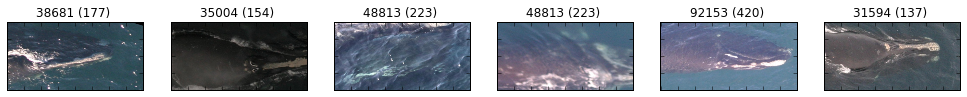

train losses ==> 6.26849746704
train scores ==> 0.00415627611801


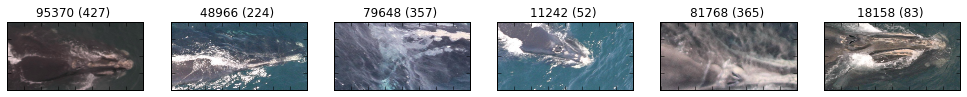

In [ ]:
if __name__ == "__main__":
    bS  = 6 # Batchsize

    ## HyperParameter defaults
    h, w, c = 200, 400, 3
    nClasses = 447
    inDims = [None,h,w,c]
    nFeatsInit = 16
    nFeatsInc = 32
    
    # Define placeholders and model 
    x = tf.placeholder(tf.float32, shape=inDims)
    y = tf.placeholder(tf.float32, shape=[None,nClasses])
    yPred = model1(x,inDims=inDims,nClasses=nClasses,nFeatsInit=nFeatsInit,nFeatsInc=nFeatsInc)

    #ce = tf.reduce_mean(-tf.reduce_sum(y*tf.log_softmax(yPred), reduction_indices=1))
    
    ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(yPred,y))
    
    trainStep = tf.train.AdamOptimizer(1e-4).minimize(ce)
    correct = tf.equal(tf.argmax(yPred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.initialize_all_variables()

    load = 0
    display = 1
    disFreq = 400
            
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(init)

        if load == 1:
            saver.restore(sess,"model.chk")

        trPerf = Performance("train")
        tePerf = Performance("test")    
        
        for epoch in range(40):
            train = dataGenerator(trainOrTest="train",bS=bS,inputSize=(w,h,c))
            test = dataGenerator(trainOrTest="test",bS=bS,inputSize=(w,h,c))
            trGen = train.generator()
            teGen = test.generator()
            
            if epoch > 1:
                trPerf.displayEpochPerformance()
                tePerf.displayEpochPerformance()

            count = 0
            while train.finishedEpoch == 0:
                XY = X,Y = next(trGen)
                
                _, loss, acc, yPred_ = sess.run([trainStep,ce,accuracy,yPred], feed_dict={x: X, y: Y})
                trPerf.add(loss,acc)
                

                if count % disFreq == 0:
                    trPerf.currentPerformance()
                    displayBatch(XY)
                count += 1
            count = 0
            while test.finishedEpoch == 0:
                XY = X,Y = next(teGen)
                loss, acc  = sess.run([ce,accuracy], feed_dict={x: X, y: Y})
                tePerf.add(loss,acc)
                
                if count % disFreq == 0:
                    tePerf.currentPerformance()
                    displayBatch(XY)
                count += 1

            trPerf.endEpoch()
            tePerf.endEpoch()
            clear_output()

        saver.save(sess,"model.chk")